In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBClassifier, XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib
import requests
import json
from tqdm import tqdm

In [2]:
# It's better to use relative paths or environment variables
try:
    df1 = pd.read_csv('datasets/diet_recommendations_dataset.csv')
    df2 = pd.read_csv('datasets/Personalized_Diet_Recommendations.csv')
    
    # Drop IDs and clean column names consistently
    for df in [df1, df2]:
        if 'Patient_ID' in df.columns:
            df.drop(columns=['Patient_ID'], inplace=True)
        df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("/", "_")
    
    # Data exploration function
    def explore_data(df, name):
        print(f"\n--- {name} Exploration ---")
        print(f"Shape: {df.shape}")
        print("\nMissing values:")
        print(df.isnull().sum())
        print("\nData types:")
        print(df.dtypes)
        print("\nSample data:")
        print(df.head())
        
        # For categorical target variables, show distribution
        if 'Diet_Recommendation' in df.columns:
            print("\nTarget distribution:")
            print(df['Diet_Recommendation'].value_counts(normalize=True))
            
    # Explore both datasets
    explore_data(df1, "Dataset 1")
    explore_data(df2, "Dataset 2")
    
except Exception as e:
    print(f"Error loading data: {e}")


--- Dataset 1 Exploration ---
Shape: (1000, 19)

Missing values:
Age                                   0
Gender                                0
Weight_kg                             0
Height_cm                             0
BMI                                   0
Disease_Type                        204
Severity                              0
Physical_Activity_Level               0
Daily_Caloric_Intake                  0
Cholesterol_mg_dL                     0
Blood_Pressure_mmHg                   0
Glucose_mg_dL                         0
Dietary_Restrictions                334
Allergies                           323
Preferred_Cuisine                     0
Weekly_Exercise_Hours                 0
Adherence_to_Diet_Plan                0
Dietary_Nutrient_Imbalance_Score      0
Diet_Recommendation                   0
dtype: int64

Data types:
Age                                   int64
Gender                               object
Weight_kg                           float64
Height_cm       

In [3]:
# Fix for Dataset 1 preprocessing and modeling
df1 = df1.dropna()

# Identify categorical columns
cat_cols = df1.select_dtypes(include='object').columns.tolist()
num_cols = df1.select_dtypes(exclude='object').columns.tolist()
if 'Diet_Recommendation' in num_cols:
    num_cols.remove('Diet_Recommendation')

# Extract features and target
X1 = df1.drop('Diet_Recommendation', axis=1)
y1 = df1['Diet_Recommendation']
le = LabelEncoder()
y1_encoded = le.fit_transform(y1)

# Create preprocessing pipelines without using column names
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), np.where(X1.dtypes != 'object')[0]),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), np.where(X1.dtypes == 'object')[0])
    ], remainder='passthrough')

# Split data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1_encoded, test_size=0.2, random_state=42, stratify=y1_encoded)

# Define model with more parameters
clf1_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y1_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

# Create a pipeline
pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf1_xgb)
])

# Cross-validation - use X1 as a numpy array
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline1, X1.values, y1_encoded, cv=cv, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train the model on the original data
pipeline1.fit(X1_train, y1_train)

# Evaluate
y1_pred = pipeline1.predict(X1_test)
print("\nDataset 1 - Test Accuracy:", accuracy_score(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0000 ± 0.0000

Dataset 1 - Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        31

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



In [4]:
# Dataset 2 preprocessing
print("\n--- Dataset 2 Processing ---")
df2 = df2.dropna()

target_class2 = 'Recommended_Meal_Plan'
target_regress2 = ['Recommended_Calories', 'Recommended_Protein', 'Recommended_Carbs', 'Recommended_Fats']

X2 = df2.drop(columns=target_regress2 + [target_class2])
y2_class = df2[target_class2]
y2_reg = df2[target_regress2]

# Identify categorical columns
cat_cols2 = X2.select_dtypes(include='object').columns.tolist()
num_cols2 = X2.select_dtypes(exclude='object').columns.tolist()

# Create preprocessing pipelines
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols2),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols2)
    ])

# Encode class target
le2 = LabelEncoder()
y2_class_encoded = le2.fit_transform(y2_class)

# Split the data
X2_train, X2_test, y2_reg_train, y2_reg_test, y2_class_train, y2_class_test = train_test_split(
    X2, y2_reg, y2_class_encoded, test_size=0.2, random_state=42, stratify=y2_class_encoded)

print(f"Training set size: {X2_train.shape}")
print(f"Test set size: {X2_test.shape}")


--- Dataset 2 Processing ---
Training set size: (525, 24)
Test set size: (132, 24)


Classification CV scores: [0.28030303 0.25757576 0.23664122 0.30534351 0.26717557]
Mean classification CV accuracy: 0.2694 ± 0.0229

Dataset 2 - Classification Accuracy: 0.24242424242424243
              precision    recall  f1-score   support

           0       0.26      0.23      0.24        31
           1       0.17      0.20      0.18        30
           2       0.21      0.21      0.21        34
           3       0.32      0.32      0.32        37

    accuracy                           0.24       132
   macro avg       0.24      0.24      0.24       132
weighted avg       0.25      0.24      0.24       132


Dataset 2 - Regression MSE: 5059.4521
Dataset 2 - Regression R²: 0.9264


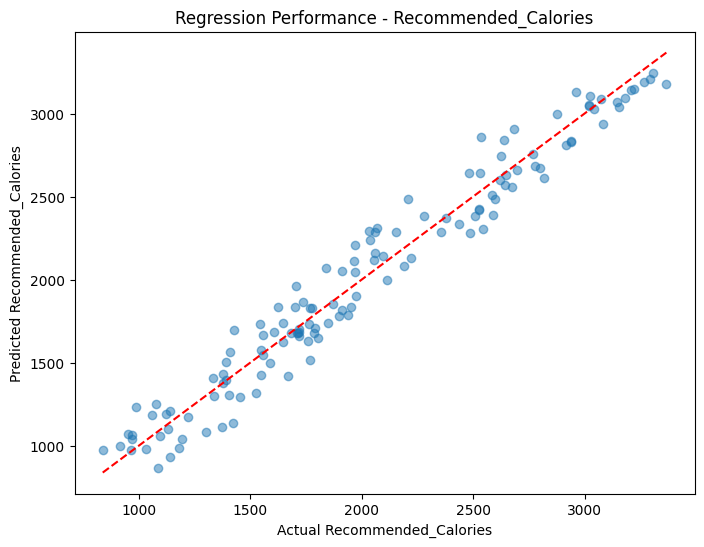

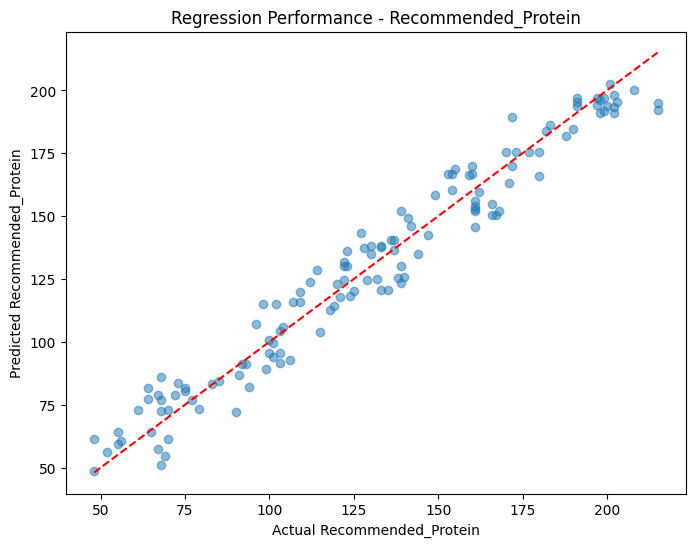

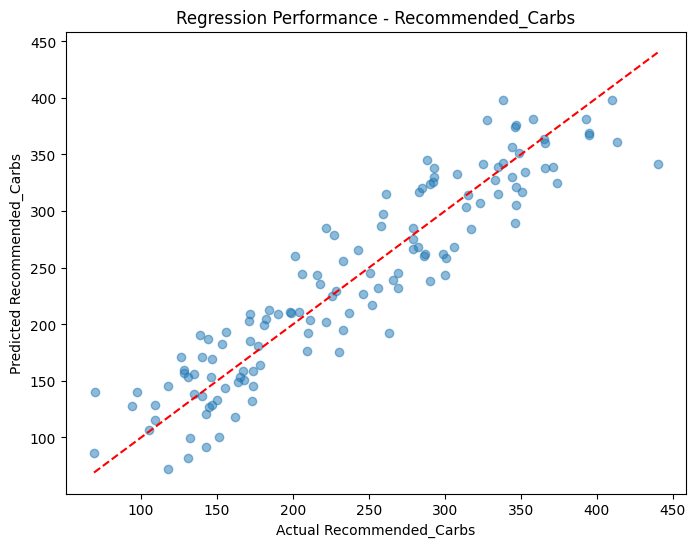

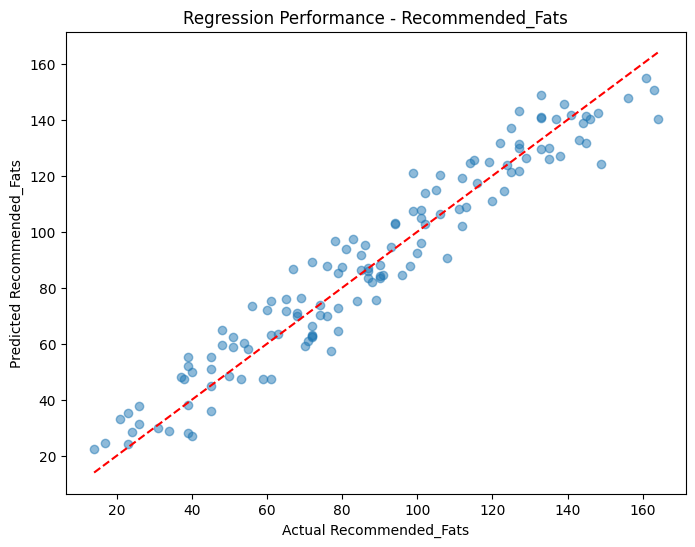

In [5]:
# Dataset 2 - Classification
clf2_pipeline = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y2_class_encoded)),
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=0.1
    ))
])

# Cross-validation for classification
cv_scores2 = cross_val_score(clf2_pipeline, X2, y2_class_encoded, cv=5, scoring='accuracy')
print(f"Classification CV scores: {cv_scores2}")
print(f"Mean classification CV accuracy: {np.mean(cv_scores2):.4f} ± {np.std(cv_scores2):.4f}")

# Train classification model
clf2_pipeline.fit(X2_train, y2_class_train)
class_preds = clf2_pipeline.predict(X2_test)
print("\nDataset 2 - Classification Accuracy:", accuracy_score(y2_class_test, class_preds))
print(classification_report(y2_class_test, class_preds))

# Dataset 2 - Regression
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor2),
    ('regressor', MultiOutputRegressor(XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1
    )))
])

# Train regression model
reg_pipeline.fit(X2_train, y2_reg_train)
reg_preds = reg_pipeline.predict(X2_test)
mse = mean_squared_error(y2_reg_test, reg_preds)
r2 = r2_score(y2_reg_test, reg_preds)
print(f"\nDataset 2 - Regression MSE: {mse:.4f}")
print(f"Dataset 2 - Regression R²: {r2:.4f}")

# Visualize regression predictions vs actual
for i, col in enumerate(target_regress2):
    plt.figure(figsize=(8, 6))
    plt.scatter(y2_reg_test.iloc[:, i], reg_preds[:, i], alpha=0.5)
    plt.xlabel(f'Actual {col}')
    plt.ylabel(f'Predicted {col}')
    plt.title(f'Regression Performance - {col}')
    
    # Add the perfect prediction line
    max_val = max(y2_reg_test.iloc[:, i].max(), reg_preds[:, i].max())
    min_val = min(y2_reg_test.iloc[:, i].min(), reg_preds[:, i].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.savefig(f'regression_plot_{col}.png')
    plt.show()

In [6]:
# Hyperparameter tuning for both classification and regression models
print("\n--- Hyperparameter Tuning ---")

# Classification tuning
class_param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5, 7],
    'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

class_random_search = RandomizedSearchCV(
    clf2_pipeline, 
    param_distributions=class_param_dist, 
    n_iter=25, 
    cv=3, 
    verbose=1, 
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

print("Tuning classification model...")
class_random_search.fit(X2_train, y2_class_train)
best_class_model = class_random_search.best_estimator_
print(f"Best classification parameters: {class_random_search.best_params_}")
print(f"Best classification CV score: {class_random_search.best_score_:.4f}")

# Evaluate best classification model
best_class_preds = best_class_model.predict(X2_test)
print(f"\nTuned Classification Accuracy: {accuracy_score(y2_class_test, best_class_preds):.4f}")
print(classification_report(y2_class_test, best_class_preds))

# Regression tuning
reg_param_dist = {
    'regressor__estimator__n_estimators': [100, 200, 300],
    'regressor__estimator__max_depth': [3, 4, 5, 6, 7],
    'regressor__estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__estimator__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__estimator__min_child_weight': [1, 3, 5, 7],
    'regressor__estimator__gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

reg_random_search = RandomizedSearchCV(
    reg_pipeline, 
    param_distributions=reg_param_dist, 
    n_iter=25, 
    cv=3, 
    verbose=1, 
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

print("\nTuning regression model...")
reg_random_search.fit(X2_train, y2_reg_train)
best_reg_model = reg_random_search.best_estimator_
print(f"Best regression parameters: {reg_random_search.best_params_}")
print(f"Best regression CV score: {-reg_random_search.best_score_:.4f}")

# Evaluate best regression model
best_reg_preds = best_reg_model.predict(X2_test)
best_mse = mean_squared_error(y2_reg_test, best_reg_preds)
best_r2 = r2_score(y2_reg_test, best_reg_preds)
print(f"\nTuned Regression MSE: {best_mse:.4f}")
print(f"Tuned Regression R²: {best_r2:.4f}")


--- Hyperparameter Tuning ---
Tuning classification model...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best classification parameters: {'classifier__subsample': 0.9, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.8}
Best classification CV score: 0.2686

Tuned Classification Accuracy: 0.2879
              precision    recall  f1-score   support

           0       0.30      0.29      0.30        31
           1       0.24      0.20      0.22        30
           2       0.21      0.24      0.22        34
           3       0.38      0.41      0.39        37

    accuracy                           0.29       132
   macro avg       0.28      0.28      0.28       132
weighted avg       0.29      0.29      0.29       132


Tuning regression model...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best regression para

In [7]:
# Save all models, pipelines, encoders, and scalers
print("\n--- Saving Models ---")

models_to_save = {
    'pipeline_dataset1': pipeline1,
    'pipeline_dataset2_classification': clf2_pipeline,
    'pipeline_dataset2_regression': reg_pipeline,
    'tuned_dataset2_classification': best_class_model,
    'tuned_dataset2_regression': best_reg_model,
    'label_encoder_dataset1': le,
    'label_encoder_dataset2': le2,
    'feature_names_dataset1': X1.columns.tolist(),
    'feature_names_dataset2': X2.columns.tolist(),
    'target_names_dataset1': list(le.classes_),
    'target_names_dataset2_class': list(le2.classes_),
    'target_names_dataset2_reg': target_regress2
}

for name, obj in models_to_save.items():
    try:
        if isinstance(obj, list):
            with open(f'{name}.json', 'w') as f:
                json.dump(obj, f)
        else:
            joblib.dump(obj, f'{name}.pkl')
        print(f"Saved {name}")
    except Exception as e:
        print(f"Failed to save {name}: {e}")

# Save model performance metrics
performance = {
    'dataset1_accuracy': accuracy_score(y1_test, y1_pred),
    'dataset2_classification_accuracy': accuracy_score(y2_class_test, class_preds),
    'dataset2_regression_mse': mse,
    'dataset2_regression_r2': r2,
    'tuned_dataset2_classification_accuracy': accuracy_score(y2_class_test, best_class_preds),
    'tuned_dataset2_regression_mse': best_mse,
    'tuned_dataset2_regression_r2': best_r2
}

with open('model_performance.json', 'w') as f:
    json.dump(performance, f)


--- Saving Models ---
Saved pipeline_dataset1
Saved pipeline_dataset2_classification
Saved pipeline_dataset2_regression
Saved tuned_dataset2_classification
Saved tuned_dataset2_regression
Saved label_encoder_dataset1
Saved label_encoder_dataset2
Saved feature_names_dataset1
Saved feature_names_dataset2
Saved target_names_dataset1
Saved target_names_dataset2_class
Saved target_names_dataset2_reg


In [9]:
import os
import numpy as np
import pandas as pd
import joblib
import requests
from sklearn.metrics import accuracy_score
from groq import Groq

# Initialize the Groq client
os.environ["GROQ_API_KEY"] = "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"  # Replace with your actual API key
client = Groq()
LLAMA_MODEL = "llama-3.3-70b-versatile"  # The model to use

def call_llama(prompt, max_tokens=1000):
    """Call the Groq API with LLaMA model using the Groq Python client."""
    try:
        completion = client.chat.completions.create(
            model=LLAMA_MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=max_tokens,
            top_p=1
        )
        
        return completion.choices[0].message.content
    except Exception as e:
        print(f"Exception: {e}")
        return None

# Function to get LLaMA insights on feature importance
def get_llama_feature_insights(feature_names, importances, dataset_name, target_var):
    """Get LLaMA insights on feature importance."""
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]
    
    # Create a description of the top features
    feature_desc = "\n".join([f"{feat}: {imp:.4f}" for feat, imp in 
                            zip(sorted_features[:10], sorted_importances[:10])])
    
    prompt = f"""
    I've trained a machine learning model to predict {target_var} using a dataset about diet recommendations.
    
    Here are the top 10 most important features and their importance scores:
    {feature_desc}
    
    Please provide insights on:
    1. Why these features might be most important for predicting {target_var}
    2. Are there any surprising features in this list? Why might they be important?
    3. What additional features might improve the model?
    4. How could these insights be used to create better diet recommendations?
    5. What patterns do you see in the important features?
    
    Please be specific and insightful.
    """
    
    return call_llama(prompt)

# Function to get LLaMA suggestions for model improvement
def get_llama_model_improvements(model_type, performance_metrics, dataset_desc):
    """Get LLaMA suggestions for model improvement."""
    prompt = f"""
    I've trained a {model_type} model on a diet recommendation dataset with the following characteristics:
    {dataset_desc}
    
    The model performance metrics are:
    {performance_metrics}
    
    Please provide detailed suggestions for:
    1. How to improve the model's performance
    2. Alternative models or architectures that might work better
    3. Feature engineering techniques that could help
    4. Model ensemble strategies to consider
    5. Specific hyperparameter tuning suggestions
    
    Please be specific and actionable in your recommendations.
    """
    
    return call_llama(prompt)

# Function to generate personalized diet explanations
def get_personalized_diet_explanation(user_features, diet_recommendation, nutrition_values):
    """Generate personalized explanation for diet recommendation."""
    prompt = f"""
    A user with the following health profile:
    {user_features}
    
    Has been recommended the following diet plan:
    {diet_recommendation}
    
    With these nutritional targets:
    {nutrition_values}
    
    Please provide:
    1. A personalized explanation of why this diet is appropriate for them
    2. How the recommended nutrition values match their specific needs
    3. Practical tips for following this diet plan
    4. Potential modifications based on lifestyle factors
    5. What specific health benefits they might expect
    
    Make it conversational, encouraging, and scientifically accurate.
    """
    
    return call_llama(prompt)

# Get LLaMA insights for the first dataset (Diet Recommendation)
try:
    # Get feature importances from the first model
    feature_names1 = X1.columns.tolist()
    importances1 = pipeline1.named_steps['classifier'].feature_importances_
    
    print("\n--- Getting LLaMA Insights for Dataset 1 ---")
    llama_insights1 = get_llama_feature_insights(
        np.array(feature_names1), 
        importances1, 
        "Diet Recommendation Dataset", 
        "Diet Type"
    )
    
    print("\nLLaMA Insights for Dataset 1:")
    print(llama_insights1)
    
    # Save the insights
    with open('llama_insights_dataset1.txt', 'w') as f:
        f.write(llama_insights1)
        
except Exception as e:
    print(f"Error getting insights for dataset 1: {e}")

# Get LLaMA insights for the second dataset (Meal Plan)
try:
    # For the classification model
    performance_metrics_class = f"""
    Accuracy: {accuracy_score(y2_class_test, best_class_preds):.4f}
    Class distribution: {np.bincount(y2_class_encoded)}
    Number of features: {X2.shape[1]}
    """
    
    dataset_desc_class = """
    This dataset contains user health information like age, weight, height, 
    activity level, health conditions, and dietary preferences.
    The target is to predict the most appropriate meal plan from 4 different options.
    """
    
    print("\n--- Getting LLaMA Suggestions for Classification Model ---")
    llama_improvements_class = get_llama_model_improvements(
        "classification",
        performance_metrics_class,
        dataset_desc_class
    )
    
    print("\nLLaMA Suggestions for Classification Model:")
    print(llama_improvements_class)
    
    # Save the suggestions
    with open('llama_improvements_classification.txt', 'w') as f:
        f.write(llama_improvements_class)
    
    # For the regression model
    performance_metrics_reg = f"""
    MSE: {best_mse:.4f}
    R²: {best_r2:.4f}
    Number of features: {X2.shape[1]}
    Target variables: {', '.join(target_regress2)}
    """
    
    dataset_desc_reg = """
    This dataset contains user health information like age, weight, height, 
    activity level, health conditions, and dietary preferences.
    The targets are to predict numerical nutritional values: daily calories, protein, carbs, and fats.
    """
    
    print("\n--- Getting LLaMA Suggestions for Regression Model ---")
    llama_improvements_reg = get_llama_model_improvements(
        "regression",
        performance_metrics_reg,
        dataset_desc_reg
    )
    
    print("\nLLaMA Suggestions for Regression Model:")
    print(llama_improvements_reg)
    
    # Save the suggestions
    with open('llama_improvements_regression.txt', 'w') as f:
        f.write(llama_improvements_reg)
        
except Exception as e:
    print(f"Error getting improvements: {e}")

# Generate a personalized explanation for a test case
try:
    # Get a sample test case
    sample_idx = np.random.randint(0, len(X2_test))
    sample_features = X2_test.iloc[sample_idx].to_dict()
    sample_meal_plan = le2.inverse_transform([y2_class_test[sample_idx]])[0]
    sample_nutrition = y2_reg_test.iloc[sample_idx].to_dict()
    
    # Create readable versions
    readable_features = "\n".join([f"- {k}: {v}" for k, v in sample_features.items()])
    readable_nutrition = "\n".join([f"- {k}: {v}" for k, v in sample_nutrition.items()])
    
    print("\n--- Generating Personalized Diet Explanation ---")
    personalized_explanation = get_personalized_diet_explanation(
        readable_features,
        f"Meal Plan: {sample_meal_plan}",
        readable_nutrition
    )
    
    print("\nPersonalized Diet Explanation:")
    print(personalized_explanation)
    
    # Save the explanation
    with open('llama_personalized_explanation.txt', 'w') as f:
        f.write(personalized_explanation)
    
except Exception as e:
    print(f"Error generating personalized explanation: {e}")

# Create a function for diet recommendation using both ML models and LLaMA
def recommend_diet_with_llama(user_features):
    """
    End-to-end function to recommend diet and generate explanation.
    
    Args:
        user_features: Dictionary with user health information
        
    Returns:
        Dictionary with diet recommendation, nutrition values, and explanation
    """
    # Convert user features to DataFrame
    user_df = pd.DataFrame([user_features])
    
    # Make predictions with the pipelines
    try:
        # Diet type prediction
        diet_type_idx = pipeline1.predict(user_df)[0]
        diet_type = le.inverse_transform([diet_type_idx])[0]
        
        # Meal plan prediction
        meal_plan_idx = best_class_model.predict(user_df)[0]
        meal_plan = le2.inverse_transform([meal_plan_idx])[0]
        
        # Nutrition values prediction
        nutrition_values = best_reg_model.predict(user_df)[0]
        nutrition_dict = {
            target_regress2[i]: nutrition_values[i] for i in range(len(target_regress2))
        }
        
        # Generate explanation with LLaMA
        readable_features = "\n".join([f"- {k}: {v}" for k, v in user_features.items()])
        readable_nutrition = "\n".join([f"- {k}: {v}" for k, v in nutrition_dict.items()])
        
        explanation = get_personalized_diet_explanation(
            readable_features,
            f"Diet Type: {diet_type}\nMeal Plan: {meal_plan}",
            readable_nutrition
        )
        
        # Return complete recommendation
        return {
            "diet_type": diet_type,
            "meal_plan": meal_plan,
            "nutrition_values": nutrition_dict,
            "explanation": explanation
        }
        
    except Exception as e:
        print(f"Error in diet recommendation: {e}")
        return {"error": str(e)}

# Save this function for later use
joblib.dump(recommend_diet_with_llama, 'recommend_diet_with_llama.pkl')

print("\n--- LLaMA Integration Complete ---")
print("You can now use the recommend_diet_with_llama function for personalized recommendations")


--- Getting LLaMA Insights for Dataset 1 ---
Error getting insights for dataset 1: index 18 is out of bounds for axis 0 with size 18

--- Getting LLaMA Suggestions for Classification Model ---

LLaMA Suggestions for Classification Model:
### 1. Improving the Model's Performance

Given the low accuracy of 0.2879, there are several steps you can take to improve the model's performance:

*   **Collect More Data**: With only 657 samples (155 + 151 + 166 + 185), the model might be underfitting due to the small dataset size. Collecting more data can help the model learn more complex patterns.
*   **Data Preprocessing**: Ensure that the data is properly preprocessed. This includes handling missing values, encoding categorical variables (e.g., activity level, health conditions, dietary preferences), and scaling/normalizing numerical features (e.g., age, weight, height).
*   **Feature Selection**: With 24 features, some might be irrelevant or redundant. Perform feature selection to identify th

In [10]:

joblib.dump(recommend_diet_with_llama, 'recommend.pkl')

['recommend.pkl']